In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, '..', 'sources'))
sys.path.insert(0, sources_path)

import time
import matplotlib.pylab as plt
from commons import *

import pyro
from pyro import poutine
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam, ExponentialLR

import torch

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

In [2]:
device = torch.device("cuda")
dtype = torch.float

# generate test data
n_samples = 1000
y_dim = 4

X = torch.randn(n_samples, device=device, dtype=dtype)

a = 5.0 * torch.randn((y_dim,), device=device, dtype=dtype)
b = 3.0 * torch.randn((y_dim,), device=device, dtype=dtype)
n = 0.5 * torch.randn((y_dim, n_samples), device=device, dtype=dtype)

y = a.unsqueeze(-1) * X + b.unsqueeze(-1) + n

Xu = X[::100]
u = y[:, ::100]

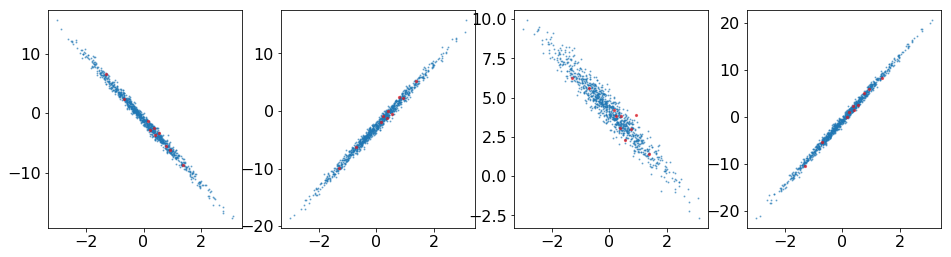

In [3]:
fig, axs = plt.subplots(ncols=y_dim, figsize=(16, 4))
for i, ax in enumerate(axs):
    ax.scatter(X.cpu().numpy(), y[i, :].cpu().numpy(), s=1, alpha=0.5)
    ax.scatter(Xu.cpu().numpy(), u[i, :].cpu().numpy(), s=5, alpha=0.5, color='red')

In [4]:
from pyro.contrib.gp.models.vsgp import VariationalSparseGP
from pyro.contrib.gp.kernels import RBF, Linear, Constant, Sum
from pyro.contrib.gp.likelihoods import Gaussian

In [5]:
kernel_rbf = RBF(
    input_dim=1,
    variance=torch.tensor(1., device=device, dtype=dtype),
    lengthscale=torch.tensor(0.5, device=device, dtype=dtype))
kernel_linear = Linear(input_dim=y_dim, variance=torch.tensor(1., device=device, dtype=dtype))
kernel_constant = Constant(input_dim=y_dim, variance=torch.tensor(1., device=device, dtype=dtype))
kernel = Sum(kernel_rbf, Sum(kernel_linear, kernel_constant))

likelihood = Gaussian(variance=torch.tensor(0.1, device=device, dtype=dtype))
gp_model = VariationalSparseGP(
    X=X,
    y=None,
    kernel=kernel,
    Xu=Xu,
    likelihood=likelihood,
    jitter=1e-3,
    latent_shape=torch.Size([y_dim]),
    whiten=True)

In [6]:
Xu

tensor([ 0.7695,  0.2417, -1.3076, -0.6964,  0.9295,  0.4154,  0.3701,  0.1726,
         1.3828,  0.5475], device='cuda:0')

In [7]:
optimizer = torch.optim.Adam(gp_model.parameters(), lr=1e-2)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500
for i in range(num_steps):
    optimizer.zero_grad()
    gp_model.set_data(X, y)
    loss = loss_fn(gp_model.model, gp_model.guide)
    if i % 100 == 0:
        print(loss.item())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)

23042.6953125


KeyboardInterrupt: 

In [8]:
gp_model.Xu

Parameter containing:
tensor([ 0.3794,  0.1778, -1.7585, -1.1467,  0.6691,  0.2841,  0.2635, -0.2442,
         1.7455,  0.3425], device='cuda:0', requires_grad=True)

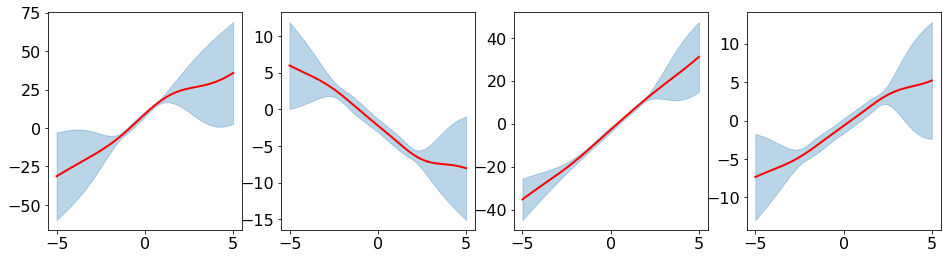

In [181]:
n_test = 500
Xtest = torch.linspace(-5, 5, n_test).to(device)  # test inputs

with torch.no_grad():
    mean, cov = gp_model(Xtest, full_cov=False)    
sd = cov.sqrt()  # standard deviation at each input point x

fig, axs = plt.subplots(ncols=y_dim, figsize=(16, 4))
for i, ax in enumerate(axs):
    
    ax.plot(Xtest.cpu().numpy(), mean[i, :].cpu().numpy(), 'r', lw=2)  # plot the mean
    ax.fill_between(Xtest.cpu().numpy(),  # plot the two-sigma uncertainty about the mean
                     (mean[i, :] - 2.0 * sd[i, :]).cpu().numpy(),
                     (mean[i, :] + 2.0 * sd[i, :]).cpu().numpy(),
                     color='C0', alpha=0.3)

In [176]:
gp_model.latent_shape

torch.Size([4])

In [169]:
likelihood.variance

tensor(0.0007, device='cuda:0')

In [186]:
from __future__ import print_function
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('0.4.0')
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

.........

KeyboardInterrupt: 